In [1]:
import pandas as pd
import matplotlib.pyplot as plt # viz
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation, PCA

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/global_issues/global-issues.csv')

In [4]:
data_df = pd.DataFrame(data).drop(columns=["url"])
data_df.head()

,Article,Class
0,That is according to the Prosecutor of the Int...,international_security
1,"Some 5,000 people have settled in several vill...",international_security
2,"The husband-and-wife owners of DC Solar, a Cal...",global_energy_politics
3,"Iraqs new prime minister, Mustafa al-Kadhimi, ...",middle_east_crisis
4,A drop in the number of new German wind power ...,global_energy_politics


In [5]:
# зададим несколько переменных, будем использовать их как параметры функций

n_features = 1000 # максимальное количество слов в матрице "слово x документ" (= top1000 частотных из всех в корпусе)
n_components = 9 # число тем в корпусе
n_top_words = 20 # порог частотности для визуализаций

In [6]:
data_df_samples, data_df_checks = train_test_split(data_df, test_size=0.2, random_state=42) 

In [7]:
print("Общий датасет: {} документов\nФрагмент для работы: {} документов\nФрагмент для проверки: {} документов".format(len(data), len(data_df_samples), len(data_df_checks)))

Общий датасет: 15532 документов
Фрагмент для работы: 12425 документов
Фрагмент для проверки: 3107 документов


In [8]:
data_samples = data_df_samples["Article"].to_list()
class_samples = data_df_samples["Class"].to_list()

data_checks = data_df_checks["Article"].to_list()
class_checks = data_df_checks["Class"].to_list()

In [9]:
UNIQ_CLASSES = sorted(list(set(data_df["Class"].to_list())))
# UNIQ_CLASSES

In [10]:
# import nltk
# nltk.download('stopwords')

In [11]:
import nltk
from nltk.corpus import stopwords 
from nltk import sent_tokenize
from nltk import word_tokenize
import re
import spacy

In [12]:
stopwords = stopwords.words('english')

In [13]:
nlp = spacy.load("en_core_web_sm")

# Functions

In [14]:
def clean_punctuation(sentence):
    return re.sub("([^\w\s])|([0-9]+)"," ", sentence)

def clean_stopwords(words, stopwords):
    result = []
    for word in words: 
        if word.lower() not in stopwords:
            result.append(word)
    return result

def tokenize_words(sentence):
    st = clean_punctuation(sentence)
    return word_tokenize(st.lower())

def lemmatize(words):
    lemmatized_words = []
    for token in nlp(' '.join(words)):
        lemmatized_words.append(token.lemma_)
    return lemmatized_words
#     return clean_stopwords(lemmatized_words, stopwords)

def lemmatize_article(article):
    words = tokenize_words(article)
    words = lemmatize(words)
    return ' '.join(words)

def lemmatize_articles(articles):
    lemmatized_articles = []
    for article in articles:
        lemmatized_articles.append(lemmatize_article(article))
    return lemmatized_articles

def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(3, 3, figsize=(30, 30)) # параметры отображения 
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1] 
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь
        
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

def init_in_topic():
    return {
        "topic 1":[0,0,0,0,0,0,0,0,0],
        "topic 2":[0,0,0,0,0,0,0,0,0],
        "topic 3":[0,0,0,0,0,0,0,0,0],
        "topic 4":[0,0,0,0,0,0,0,0,0],
        "topic 5":[0,0,0,0,0,0,0,0,0],
        "topic 6":[0,0,0,0,0,0,0,0,0],
        "topic 7":[0,0,0,0,0,0,0,0,0],
        "topic 8":[0,0,0,0,0,0,0,0,0],
        "topic 9":[0,0,0,0,0,0,0,0,0]
    }
    
def class_in_topic_counts(topics, classes):
    in_topic = init_in_topic()

    for n in range(topics.shape[0]):
        topic_most_pr = "topic " + str(topics[n].argmax() + 1)
        fr = in_topic.get(topic_most_pr)
        index = UNIQ_CLASSES.index(classes[n])
        fr[index] = fr[index] + 1
        in_topic[topic_most_pr] = fr
    return in_topic

def class_in_topic_counts2(topics, classes):
    in_topic = init_in_topic()

    for n, element in enumerate(topics):
        topic_most_pr = "topic " + str(element + 1)
        fr = in_topic.get(topic_most_pr)
        index = UNIQ_CLASSES.index(classes[n])
        fr[index] = fr[index] + 1
        in_topic[topic_most_pr] = fr
    return in_topic


In [15]:
lemmatized_samples = lemmatize_articles(data_samples)

In [16]:
lemmatized_checks = lemmatize_articles(data_checks)

In [17]:
tf_samples_vectorizer = CountVectorizer(max_df=0.95, min_df=2, # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')
tf_samples = tf_samples_vectorizer.fit_transform(lemmatized_samples)

In [18]:
tf_checks_vectorizer = CountVectorizer(max_df=0.95, min_df=2, # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')
tf_checks = tf_checks_vectorizer.fit_transform(lemmatized_checks)

# LDA

In [19]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, learning_offset=50)
lda.fit(tf_samples)

LatentDirichletAllocation(learning_offset=50, max_iter=20, n_components=9)

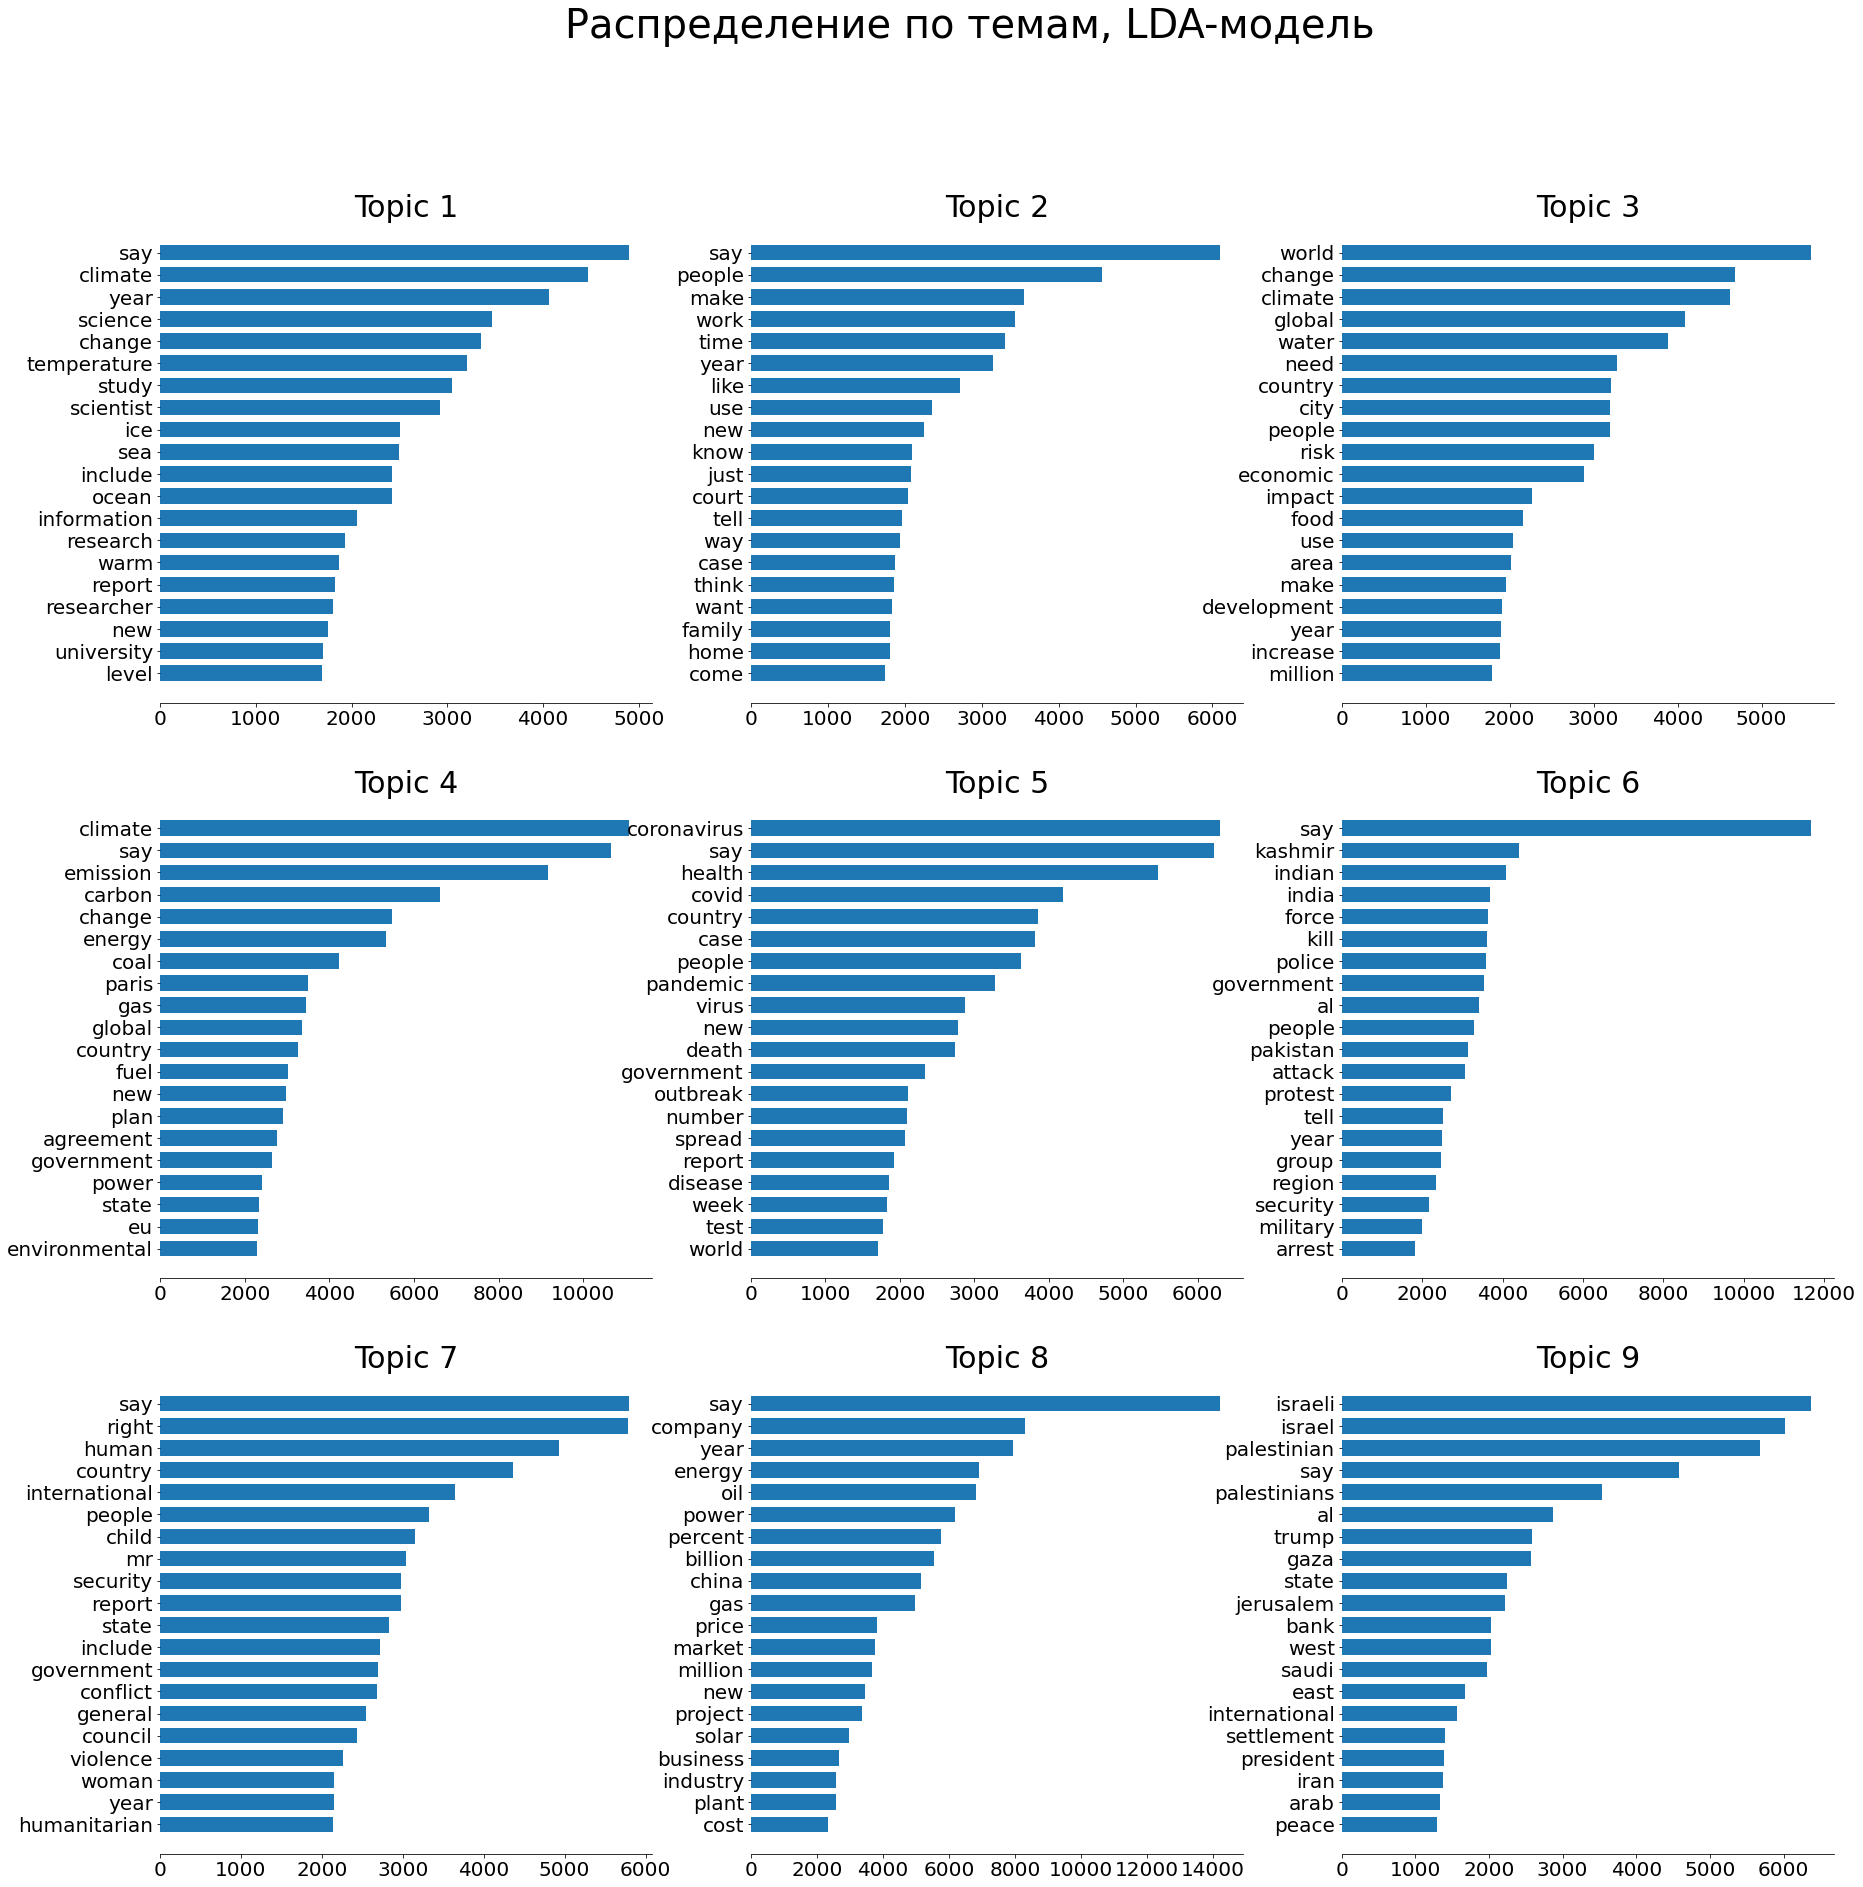

In [20]:
tf_feature_names = tf_samples_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Распределение по темам, LDA-модель')

In [21]:
lda_samples_topic = lda.transform(tf_samples)

In [22]:
lda_samples_class_in_topic = class_in_topic_counts(lda_samples_topic, class_samples)
lda_samples_class_in_topic

{'topic 1': [1150, 2, 85, 0, 3, 1, 1, 1, 0],
 'topic 2': [117, 127, 37, 199, 187, 15, 35, 11, 33],
 'topic 3': [811, 132, 66, 18, 195, 2, 9, 4, 1],
 'topic 4': [528, 4, 1227, 9, 17, 0, 3, 0, 0],
 'topic 5': [16, 386, 19, 34, 296, 1, 219, 2, 2],
 'topic 6': [27, 2, 39, 221, 243, 431, 161, 1, 89],
 'topic 7': [82, 4, 9, 790, 1026, 3, 49, 1, 5],
 'topic 8': [128, 25, 2059, 6, 62, 1, 73, 4, 0],
 'topic 9': [1, 1, 7, 32, 66, 0, 153, 2, 617]}

In [23]:
lda_checks_topic = lda.transform(tf_checks)

In [24]:
lda_checks_class_in_topic = class_in_topic_counts(lda_checks_topic, class_checks)
lda_checks_class_in_topic

{'topic 1': [177, 3, 20, 2, 10, 1, 4, 1, 0],
 'topic 2': [227, 69, 136, 74, 136, 6, 26, 1, 33],
 'topic 3': [104, 26, 43, 12, 69, 0, 12, 3, 5],
 'topic 4': [60, 2, 130, 1, 3, 0, 0, 4, 1],
 'topic 5': [16, 17, 7, 2, 22, 0, 9, 0, 35],
 'topic 6': [8, 2, 17, 15, 32, 104, 4, 0, 9],
 'topic 7': [16, 3, 5, 128, 150, 3, 8, 0, 3],
 'topic 8': [79, 44, 460, 78, 91, 3, 64, 1, 32],
 'topic 9': [16, 3, 64, 16, 31, 3, 41, 1, 64]}

# PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(tf_samples.toarray())

PCA(n_components=9, svd_solver='full')

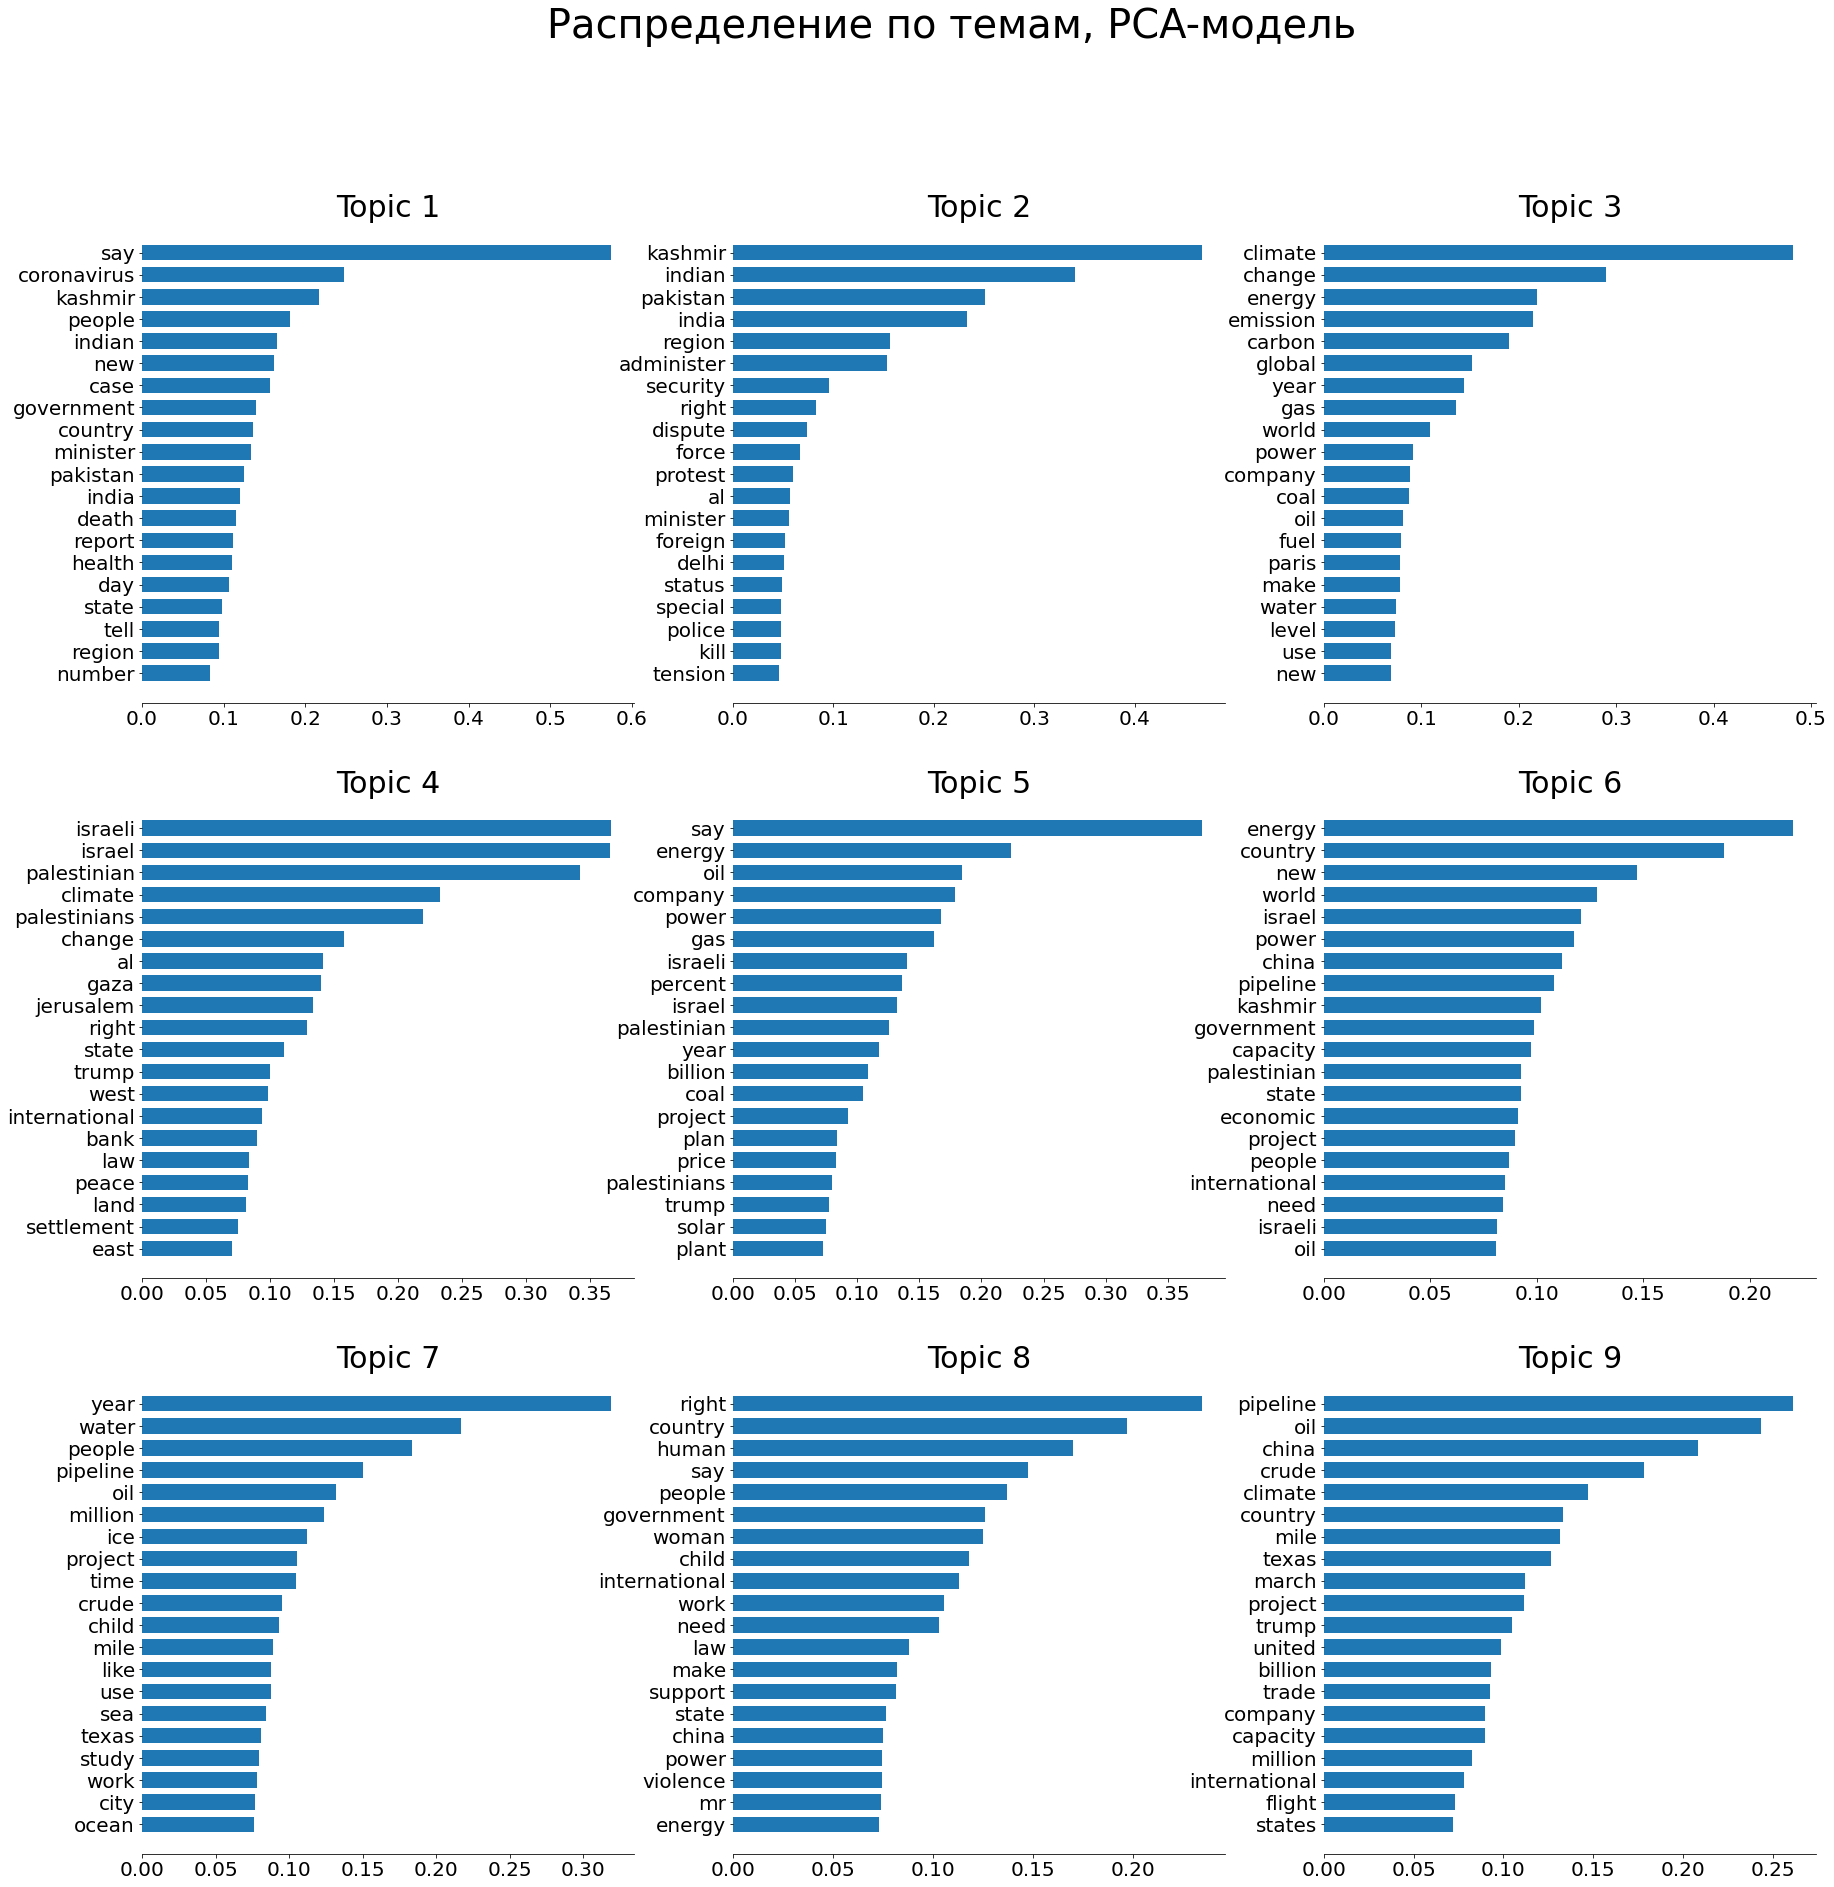

In [27]:
tf_feature_names = tf_samples_vectorizer.get_feature_names()
plot_top_words(pca, tf_feature_names, n_top_words, 'Распределение по темам, PCA-модель')

In [28]:
pca_samples_topic = pca.transform(tf_samples.toarray())

In [83]:
pca_samples_class_in_topic = class_in_topic_counts(pca_samples_topic, class_samples)
pca_samples_class_in_topic

{'topic 1': [101, 63, 77, 189, 84, 69, 229, 1, 1],
 'topic 2': [344, 25, 88, 214, 644, 384, 170, 2, 42],
 'topic 3': [1310, 8, 894, 4, 22, 0, 0, 0, 0],
 'topic 4': [7, 1, 3, 44, 47, 0, 49, 0, 696],
 'topic 5': [57, 9, 1996, 10, 26, 0, 45, 1, 6],
 'topic 6': [211, 413, 128, 36, 530, 0, 58, 14, 1],
 'topic 7': [645, 104, 92, 88, 165, 1, 20, 2, 0],
 'topic 8': [51, 13, 25, 710, 422, 0, 38, 2, 1],
 'topic 9': [134, 47, 245, 14, 155, 0, 94, 4, 0]}

In [30]:
pca_checks_topic = pca.transform(tf_checks.toarray())

In [31]:
pca_checks_class_in_topic = class_in_topic_counts(pca_checks_topic, class_checks)
# pca_checks_class_in_topic

# FactorAnalysis

In [32]:
from sklearn.decomposition import FactorAnalysis

In [33]:
fa = FactorAnalysis(n_components=n_components, random_state=42)
fa.fit(tf_samples.toarray())

FactorAnalysis(n_components=9, random_state=42)

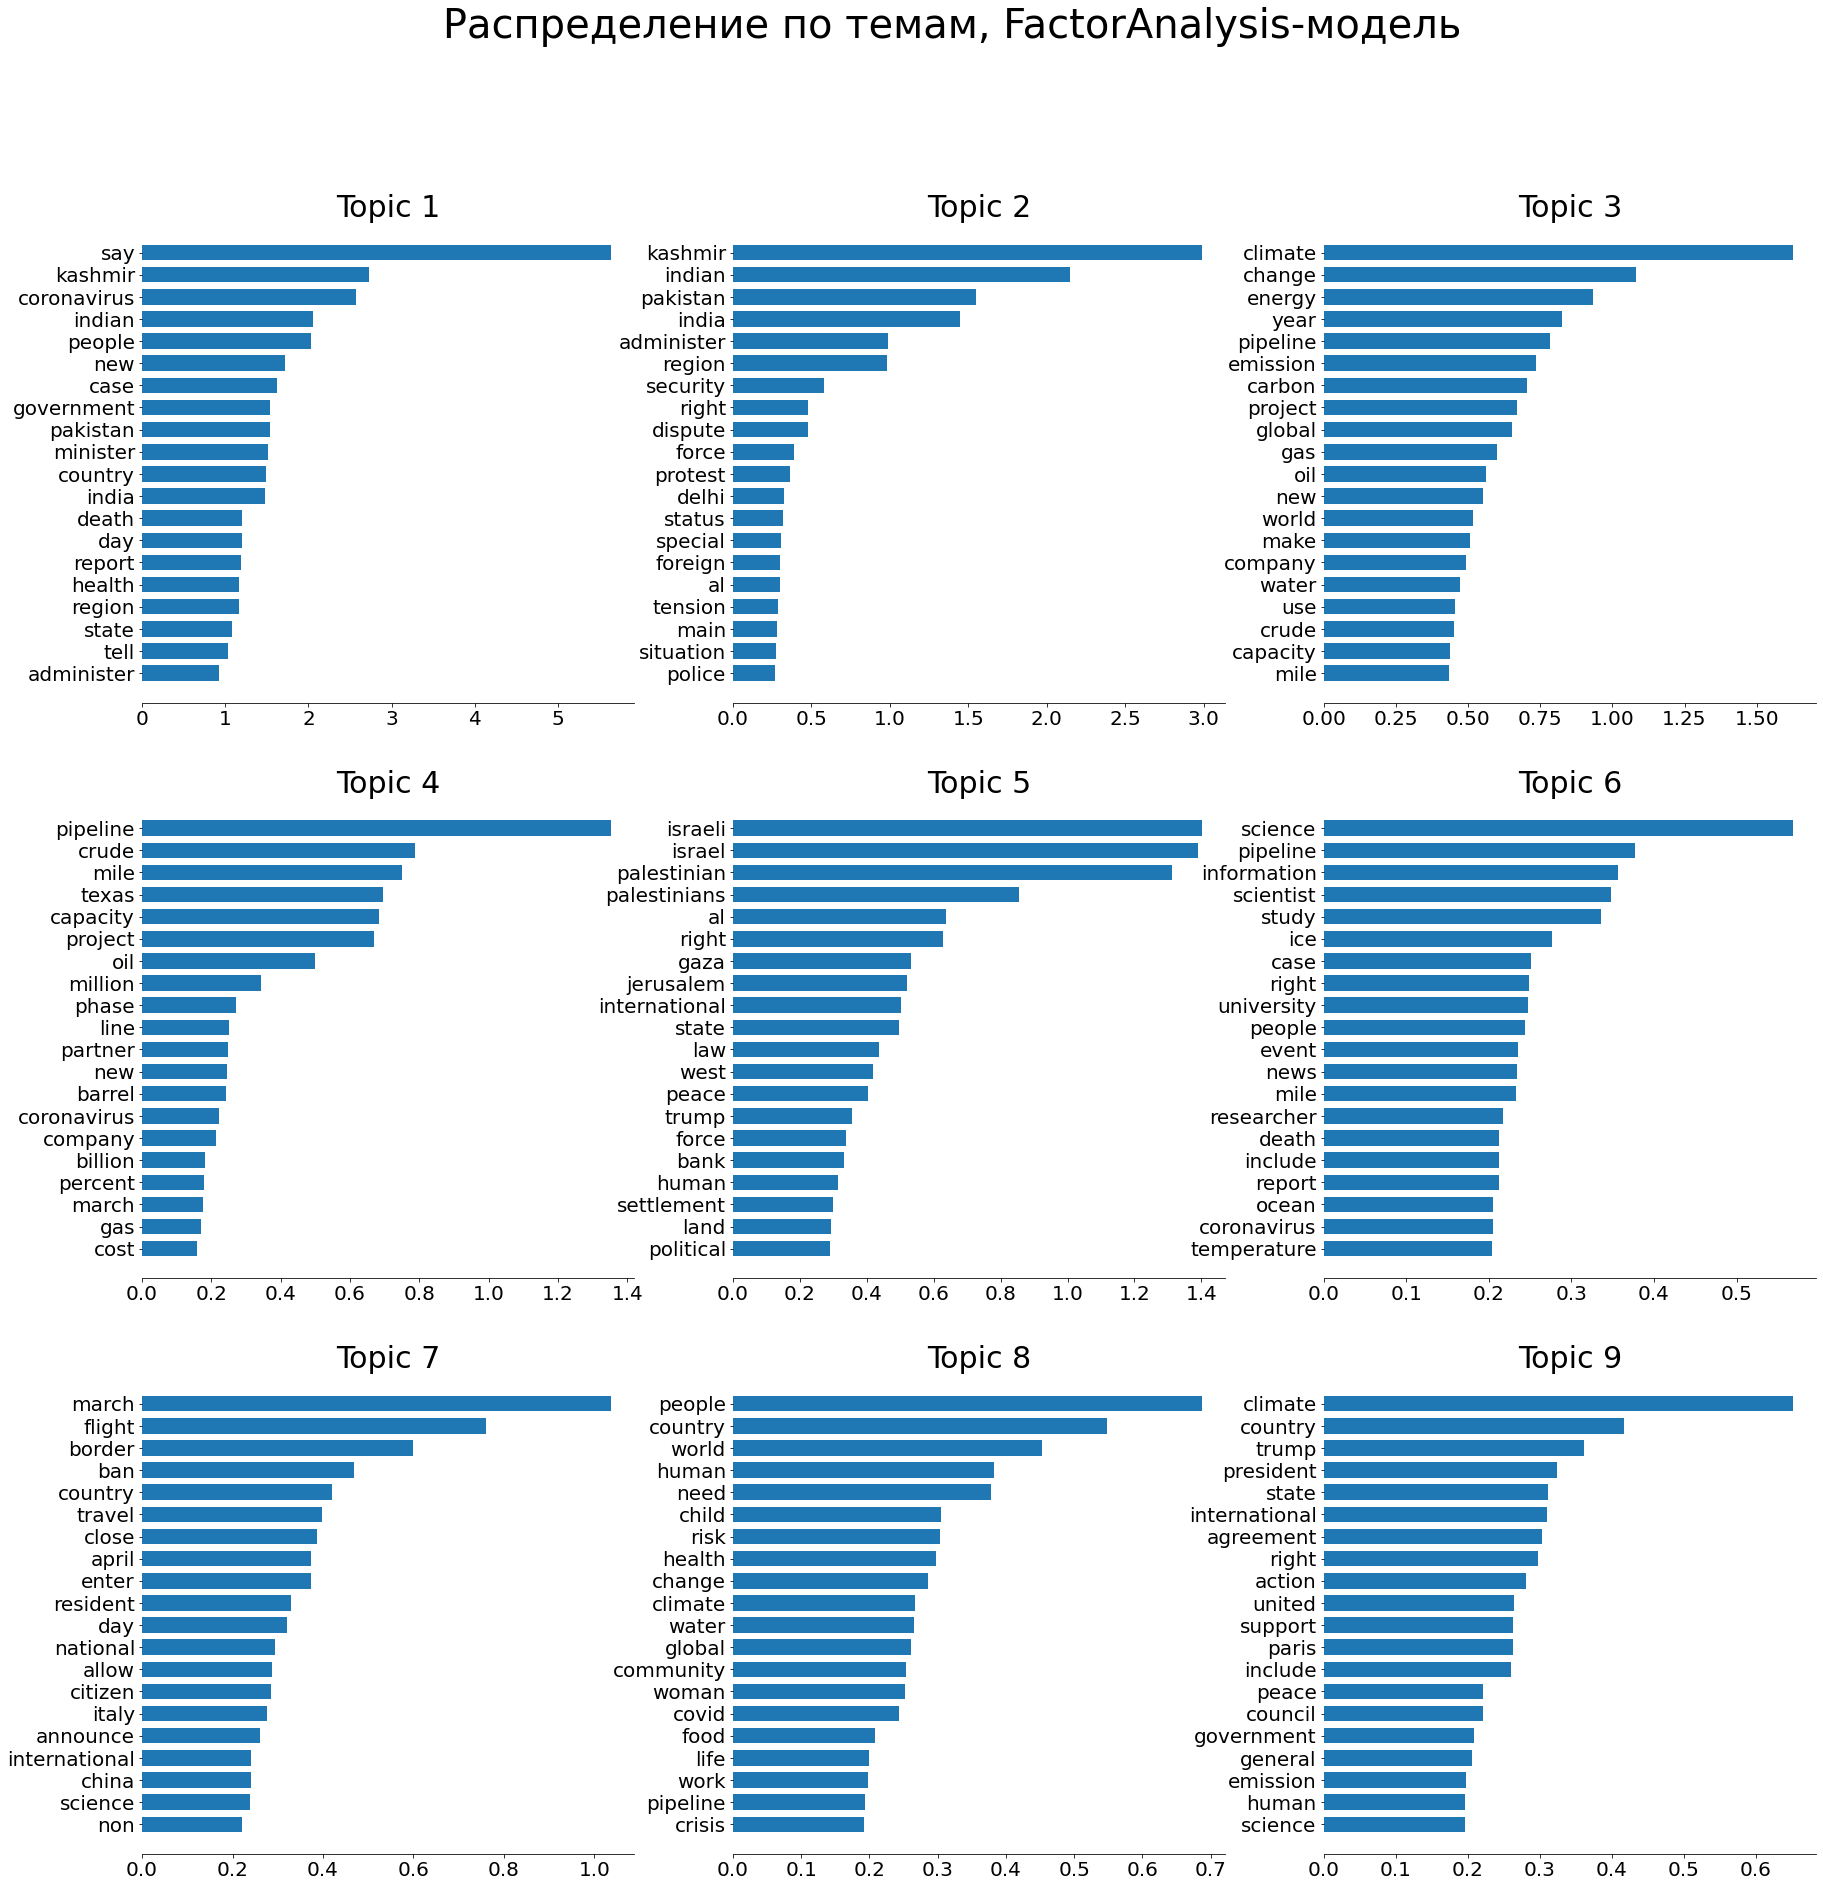

In [34]:
tf_feature_names = tf_samples_vectorizer.get_feature_names()
plot_top_words(fa, tf_feature_names, n_top_words, 'Распределение по темам, FactorAnalysis-модель')

In [35]:
fa_samples_topic = fa.transform(tf_samples.toarray())

In [84]:
fa_samples_class_in_topic = class_in_topic_counts(fa_samples_topic, class_samples)
fa_samples_class_in_topic

{'topic 1': [6, 15, 9, 3, 4, 16, 71, 0, 0],
 'topic 2': [10, 0, 15, 35, 27, 401, 1, 0, 0],
 'topic 3': [608, 22, 743, 5, 35, 2, 9, 4, 0],
 'topic 4': [132, 51, 1610, 66, 184, 10, 267, 7, 45],
 'topic 5': [37, 0, 10, 356, 139, 9, 165, 2, 684],
 'topic 6': [956, 57, 60, 92, 172, 7, 39, 1, 3],
 'topic 7': [61, 41, 180, 18, 39, 0, 26, 0, 2],
 'topic 8': [752, 481, 52, 421, 907, 6, 46, 7, 1],
 'topic 9': [298, 16, 869, 313, 588, 3, 79, 5, 12]}

In [37]:
fa_checks_topic = fa.transform(tf_checks.toarray())

In [85]:
fa_checks_class_in_topic = class_in_topic_counts(fa_checks_topic, class_checks)
fa_checks_class_in_topic

{'topic 1': [1, 1, 8, 0, 1, 3, 3, 1, 1],
 'topic 2': [6, 1, 70, 15, 25, 65, 0, 0, 1],
 'topic 3': [164, 29, 194, 15, 35, 0, 22, 5, 5],
 'topic 4': [54, 31, 230, 68, 87, 12, 69, 0, 35],
 'topic 5': [54, 5, 69, 74, 57, 25, 42, 2, 88],
 'topic 6': [179, 51, 54, 37, 129, 8, 10, 2, 0],
 'topic 7': [128, 5, 141, 21, 19, 3, 11, 0, 37],
 'topic 8': [107, 41, 65, 68, 165, 3, 8, 1, 9],
 'topic 9': [10, 5, 51, 30, 26, 1, 3, 0, 6]}

# KMeans

In [39]:
from sklearn.cluster import KMeans

In [40]:
km = KMeans(n_clusters=n_components)
km.fit(tf_samples)

KMeans(n_clusters=9)

In [41]:
# print (km.labels_)

In [42]:
km_samples_topic = km.predict(tf_samples)

In [43]:
km_samples_class_in_topic = class_in_topic_counts2(km_samples_topic, class_samples)
km_samples_class_in_topic

{'topic 1': [0, 0, 1, 11, 10, 0, 34, 0, 567],
 'topic 2': [1070, 9, 390, 3, 22, 0, 0, 0, 0],
 'topic 3': [0, 0, 0, 0, 0, 0, 44, 0, 0],
 'topic 4': [79, 16, 47, 338, 128, 309, 143, 2, 9],
 'topic 5': [0, 0, 0, 1, 0, 1, 1, 0, 0],
 'topic 6': [0, 0, 0, 1, 0, 1, 0, 0, 0],
 'topic 7': [1508, 642, 1204, 954, 1912, 143, 447, 22, 171],
 'topic 8': [203, 16, 1905, 1, 23, 0, 34, 2, 0],
 'topic 9': [0, 0, 1, 0, 0, 0, 0, 0, 0]}

In [44]:
km_checks_topic = km.predict(tf_checks)

In [45]:
km_checks_class_in_topic = class_in_topic_counts2(km_checks_topic, class_checks)
km_checks_class_in_topic

{'topic 1': [2, 0, 0, 0, 0, 1, 1, 0, 0],
 'topic 2': [10, 0, 1, 0, 0, 0, 0, 0, 0],
 'topic 3': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 4': [0, 0, 0, 2, 0, 4, 11, 0, 1],
 'topic 5': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 6': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 7': [670, 168, 861, 325, 542, 115, 155, 10, 180],
 'topic 8': [21, 1, 20, 1, 2, 0, 1, 1, 1],
 'topic 9': [0, 0, 0, 0, 0, 0, 0, 0, 0]}

# Birch

In [46]:
from sklearn.cluster import Birch

In [47]:
brc = Birch(n_clusters=n_components)
brc.fit(tf_samples)

Birch(n_clusters=9)

In [48]:
brc_samples_topic = brc.predict(tf_samples)

In [49]:
brc_samples_class_in_topic = class_in_topic_counts2(brc_samples_topic, class_samples)
brc_samples_class_in_topic

{'topic 1': [0, 0, 0, 0, 0, 1, 1, 0, 0],
 'topic 2': [58, 10, 11, 182, 51, 381, 33, 0, 10],
 'topic 3': [1591, 21, 984, 10, 64, 1, 3, 2, 0],
 'topic 4': [329, 41, 2368, 31, 65, 2, 65, 4, 0],
 'topic 5': [1, 1, 1, 39, 49, 2, 52, 0, 680],
 'topic 6': [0, 0, 0, 1, 0, 1, 0, 0, 0],
 'topic 7': [881, 610, 183, 1046, 1866, 66, 505, 20, 57],
 'topic 8': [0, 0, 1, 0, 0, 0, 0, 0, 0],
 'topic 9': [0, 0, 0, 0, 0, 0, 44, 0, 0]}

In [50]:
brc_checks_topic = brc.predict(tf_checks)

In [51]:
brc_checks_class_in_topic = class_in_topic_counts2(brc_checks_topic, class_checks)
brc_checks_class_in_topic

{'topic 1': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 2': [2, 0, 0, 0, 0, 16, 0, 0, 0],
 'topic 3': [55, 2, 32, 1, 4, 0, 2, 1, 3],
 'topic 4': [52, 4, 77, 7, 10, 0, 3, 4, 9],
 'topic 5': [5, 0, 1, 0, 0, 2, 1, 0, 3],
 'topic 6': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 7': [589, 163, 772, 320, 530, 102, 162, 6, 167],
 'topic 8': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 9': [0, 0, 0, 0, 0, 0, 0, 0, 0]}

# FeatureAgglomeration

In [52]:
from sklearn.cluster import FeatureAgglomeration

In [53]:
fag = FeatureAgglomeration(n_clusters=n_components)
fag.fit(tf_samples.toarray())

FeatureAgglomeration(n_clusters=9)

In [54]:
fag_samples_topic = fag.transform(tf_samples.toarray())

In [58]:
fag_samples_class_in_topic = class_in_topic_counts(fag_samples_topic, class_samples)
fag_samples_class_in_topic

{'topic 1': [52, 10, 10, 0, 14, 0, 1, 0, 0],
 'topic 2': [40, 149, 3, 29, 130, 0, 51, 1, 2],
 'topic 3': [271, 208, 104, 135, 500, 3, 52, 13, 6],
 'topic 4': [4, 0, 6, 11, 18, 196, 2, 1, 0],
 'topic 5': [3, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 6': [1243, 41, 265, 12, 92, 0, 2, 0, 0],
 'topic 7': [5, 2, 1, 1, 10, 0, 1, 0, 0],
 'topic 8': [1242, 272, 3158, 1108, 1313, 254, 564, 11, 351],
 'topic 9': [0, 1, 1, 13, 18, 1, 30, 0, 388]}

In [56]:
fag_checks_topic = fag.transform(tf_checks.toarray())

In [59]:
fag_checks_class_in_topic = class_in_topic_counts(fag_checks_topic, class_checks)
fag_checks_class_in_topic

{'topic 1': [159, 28, 306, 57, 73, 0, 27, 2, 3],
 'topic 2': [77, 60, 163, 67, 101, 0, 47, 1, 38],
 'topic 3': [31, 8, 81, 63, 135, 0, 36, 3, 57],
 'topic 4': [60, 10, 95, 23, 29, 107, 7, 2, 5],
 'topic 5': [34, 2, 19, 2, 7, 1, 8, 0, 1],
 'topic 6': [168, 44, 138, 55, 99, 1, 15, 3, 21],
 'topic 7': [37, 9, 35, 30, 45, 0, 12, 0, 56],
 'topic 8': [75, 6, 19, 8, 12, 0, 3, 0, 0],
 'topic 9': [62, 2, 26, 23, 43, 11, 13, 0, 1]}

# Data Frames

In [60]:
lda_samples_class_in_topic

{'topic 1': [1150, 2, 85, 0, 3, 1, 1, 1, 0],
 'topic 2': [117, 127, 37, 199, 187, 15, 35, 11, 33],
 'topic 3': [811, 132, 66, 18, 195, 2, 9, 4, 1],
 'topic 4': [528, 4, 1227, 9, 17, 0, 3, 0, 0],
 'topic 5': [16, 386, 19, 34, 296, 1, 219, 2, 2],
 'topic 6': [27, 2, 39, 221, 243, 431, 161, 1, 89],
 'topic 7': [82, 4, 9, 790, 1026, 3, 49, 1, 5],
 'topic 8': [128, 25, 2059, 6, 62, 1, 73, 4, 0],
 'topic 9': [1, 1, 7, 32, 66, 0, 153, 2, 617]}

In [61]:
df = pd.DataFrame.from_dict(lda_samples_class_in_topic, orient='index', columns=UNIQ_CLASSES)
df

,climate_change,covid19,global_energy_politics,human_rights,international_security,kashmir_issue,middle_east_crisis,nuclear_security,palestine_conflict
topic 1,1150,2,85,0,3,1,1,1,0
topic 2,117,127,37,199,187,15,35,11,33
topic 3,811,132,66,18,195,2,9,4,1
topic 4,528,4,1227,9,17,0,3,0,0
topic 5,16,386,19,34,296,1,219,2,2
topic 6,27,2,39,221,243,431,161,1,89
topic 7,82,4,9,790,1026,3,49,1,5
topic 8,128,25,2059,6,62,1,73,4,0
topic 9,1,1,7,32,66,0,153,2,617


In [62]:
df.to_csv("C:/Users/rigel/Desktop/ВШЭ/финальный_проект/lda_df.csv")

In [63]:
pca_samples_class_in_topic

{'topic 1': [101, 63, 77, 189, 84, 69, 229, 1, 1],
 'topic 2': [344, 25, 88, 214, 644, 384, 170, 2, 42],
 'topic 3': [1310, 8, 894, 4, 22, 0, 0, 0, 0],
 'topic 4': [7, 1, 3, 44, 47, 0, 49, 0, 696],
 'topic 5': [57, 9, 1996, 10, 26, 0, 45, 1, 6],
 'topic 6': [211, 413, 128, 36, 530, 0, 58, 14, 1],
 'topic 7': [645, 104, 92, 88, 165, 1, 20, 2, 0],
 'topic 8': [51, 13, 25, 710, 422, 0, 38, 2, 1],
 'topic 9': [134, 47, 245, 14, 155, 0, 94, 4, 0]}

In [64]:
df2 = pd.DataFrame.from_dict(pca_samples_class_in_topic, orient='index', columns=UNIQ_CLASSES)
df2

,climate_change,covid19,global_energy_politics,human_rights,international_security,kashmir_issue,middle_east_crisis,nuclear_security,palestine_conflict
topic 1,101,63,77,189,84,69,229,1,1
topic 2,344,25,88,214,644,384,170,2,42
topic 3,1310,8,894,4,22,0,0,0,0
topic 4,7,1,3,44,47,0,49,0,696
topic 5,57,9,1996,10,26,0,45,1,6
topic 6,211,413,128,36,530,0,58,14,1
topic 7,645,104,92,88,165,1,20,2,0
topic 8,51,13,25,710,422,0,38,2,1
topic 9,134,47,245,14,155,0,94,4,0


In [65]:
df2.to_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/pca_df.csv')

In [66]:
fa_samples_class_in_topic

{'topic 1': [6, 15, 9, 3, 4, 16, 71, 0, 0],
 'topic 2': [10, 0, 15, 35, 27, 401, 1, 0, 0],
 'topic 3': [608, 22, 743, 5, 35, 2, 9, 4, 0],
 'topic 4': [132, 51, 1610, 66, 184, 10, 267, 7, 45],
 'topic 5': [37, 0, 10, 356, 139, 9, 165, 2, 684],
 'topic 6': [956, 57, 60, 92, 172, 7, 39, 1, 3],
 'topic 7': [61, 41, 180, 18, 39, 0, 26, 0, 2],
 'topic 8': [752, 481, 52, 421, 907, 6, 46, 7, 1],
 'topic 9': [298, 16, 869, 313, 588, 3, 79, 5, 12]}

In [67]:
df3 = pd.DataFrame.from_dict(fa_samples_class_in_topic, orient='index', columns=UNIQ_CLASSES)
df3

,climate_change,covid19,global_energy_politics,human_rights,international_security,kashmir_issue,middle_east_crisis,nuclear_security,palestine_conflict
topic 1,6,15,9,3,4,16,71,0,0
topic 2,10,0,15,35,27,401,1,0,0
topic 3,608,22,743,5,35,2,9,4,0
topic 4,132,51,1610,66,184,10,267,7,45
topic 5,37,0,10,356,139,9,165,2,684
topic 6,956,57,60,92,172,7,39,1,3
topic 7,61,41,180,18,39,0,26,0,2
topic 8,752,481,52,421,907,6,46,7,1
topic 9,298,16,869,313,588,3,79,5,12


In [68]:
df3.to_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/fa_df.csv')

In [69]:
df4 = pd.DataFrame.from_dict(km_samples_class_in_topic, orient='index', columns=UNIQ_CLASSES)
df4

,climate_change,covid19,global_energy_politics,human_rights,international_security,kashmir_issue,middle_east_crisis,nuclear_security,palestine_conflict
topic 1,0,0,1,11,10,0,34,0,567
topic 2,1070,9,390,3,22,0,0,0,0
topic 3,0,0,0,0,0,0,44,0,0
topic 4,79,16,47,338,128,309,143,2,9
topic 5,0,0,0,1,0,1,1,0,0
topic 6,0,0,0,1,0,1,0,0,0
topic 7,1508,642,1204,954,1912,143,447,22,171
topic 8,203,16,1905,1,23,0,34,2,0
topic 9,0,0,1,0,0,0,0,0,0


In [70]:
df4.to_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/km_df.csv')

In [71]:
brc_checks_class_in_topic

{'topic 1': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 2': [2, 0, 0, 0, 0, 16, 0, 0, 0],
 'topic 3': [55, 2, 32, 1, 4, 0, 2, 1, 3],
 'topic 4': [52, 4, 77, 7, 10, 0, 3, 4, 9],
 'topic 5': [5, 0, 1, 0, 0, 2, 1, 0, 3],
 'topic 6': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 7': [589, 163, 772, 320, 530, 102, 162, 6, 167],
 'topic 8': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 9': [0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [72]:
df5 = pd.DataFrame.from_dict(brc_samples_class_in_topic, orient='index', columns=UNIQ_CLASSES)
df5

,climate_change,covid19,global_energy_politics,human_rights,international_security,kashmir_issue,middle_east_crisis,nuclear_security,palestine_conflict
topic 1,0,0,0,0,0,1,1,0,0
topic 2,58,10,11,182,51,381,33,0,10
topic 3,1591,21,984,10,64,1,3,2,0
topic 4,329,41,2368,31,65,2,65,4,0
topic 5,1,1,1,39,49,2,52,0,680
topic 6,0,0,0,1,0,1,0,0,0
topic 7,881,610,183,1046,1866,66,505,20,57
topic 8,0,0,1,0,0,0,0,0,0
topic 9,0,0,0,0,0,0,44,0,0


In [73]:
df5.to_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/brc_df.csv')

In [74]:
fag_samples_class_in_topic

{'topic 1': [52, 10, 10, 0, 14, 0, 1, 0, 0],
 'topic 2': [40, 149, 3, 29, 130, 0, 51, 1, 2],
 'topic 3': [271, 208, 104, 135, 500, 3, 52, 13, 6],
 'topic 4': [4, 0, 6, 11, 18, 196, 2, 1, 0],
 'topic 5': [3, 0, 0, 0, 0, 0, 0, 0, 0],
 'topic 6': [1243, 41, 265, 12, 92, 0, 2, 0, 0],
 'topic 7': [5, 2, 1, 1, 10, 0, 1, 0, 0],
 'topic 8': [1242, 272, 3158, 1108, 1313, 254, 564, 11, 351],
 'topic 9': [0, 1, 1, 13, 18, 1, 30, 0, 388]}

In [75]:
df6 = pd.DataFrame.from_dict(fag_samples_class_in_topic, orient='index', columns=UNIQ_CLASSES)
df6

,climate_change,covid19,global_energy_politics,human_rights,international_security,kashmir_issue,middle_east_crisis,nuclear_security,palestine_conflict
topic 1,52,10,10,0,14,0,1,0,0
topic 2,40,149,3,29,130,0,51,1,2
topic 3,271,208,104,135,500,3,52,13,6
topic 4,4,0,6,11,18,196,2,1,0
topic 5,3,0,0,0,0,0,0,0,0
topic 6,1243,41,265,12,92,0,2,0,0
topic 7,5,2,1,1,10,0,1,0,0
topic 8,1242,272,3158,1108,1313,254,564,11,351
topic 9,0,1,1,13,18,1,30,0,388


In [76]:
df6.to_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/fag_df.csv')

In [77]:
df = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/lda_df.csv')

In [78]:
df2 = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/pca_df.csv')

In [79]:
df3 = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/fa_df.csv')

In [80]:
df4 = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/km_df.csv')

In [81]:
df5 = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/brc_df.csv')

In [82]:
df6 = pd.read_csv('C:/Users/rigel/Desktop/ВШЭ/финальный_проект/fag_df.csv')